# The Lottery Ticket Hypothesis: _LeNet-5_ Convolutional Neural Network for MNIST

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [5]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 28, 28, 1), y_train = (60000, 10)
X_test.shape = (10000, 28, 28, 1), y_test = (10000, 10)


### Prepare MNIST dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0012)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [15]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  100000


In [16]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [17]:
l = tf.keras.layers

In [18]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following LeNet-5 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 6, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid',
            input_shape=(28, 28, 1)
        ),
        **pruning_params_conv)
    )
       
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 16, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
   
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 120, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 84, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 10, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model
    


In [19]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [20]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [21]:
# Load Randomly Initialized weights from before-
# orig_model.load_weights("LeNet_5_MNIST_Random_Weights.h5")

In [21]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [22]:
# Save random weights-
orig_model.save_weights("LeNet_5_MNIST_Random_Weights.h5", overwrite=True)

In [23]:
# Save random weights-
orig_model.save_weights("LeNet_5_MNIST_Winning_Ticket.h5", overwrite=True)

In [24]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [ ]:
# Sanity check: Whether defined CNN works as intended-
'''
history = orig_model.fit(
    x = X_train, y = y_train,
    epochs=num_epochs, batch_size=batch_size,
    verbose=1, shuffle=True,
    callbacks=callback,
    validation_data=(X_test, y_test)
)
'''

In [26]:
# orig_model.evaluate(X_test, y_test, verbose = 0)

[0.06896029367350129, 0.9828]

### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic, where the fully-connected (fc) layers are pruned at the rate of 20% per iterative
pruning round and the convolutional (conv) layers are pruned at the rate of 10% per iterative pruning round.

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [25]:
# number of convolutional parameters-
conv1 = 60
conv2 = 880

# number of fully-connected dense parameters-
dense1 = 48120
dense2 = 10164
op_layer = 850


# total number of parameters-
total_params = conv1 + conv2 + dense1 + dense2 + op_layer

print("\nTotal number of trainable parameters = {0}\n".format(total_params))


Total number of trainable parameters = 60074



In [26]:
# maximum pruning performed is till 0.5% of all parameters-
max_pruned_params = 0.005 * total_params

In [27]:
loc_tot_params = total_params
loc_conv1 = conv1
loc_conv2 = conv2
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer

# variable to count number of pruning rounds-
n = 0

In [28]:
# Lists to hold percentage of weights pruned in each round for all layers in CNN-
conv1_pruning = []
conv2_pruning = []
dense1_pruning = []
dense2_pruning = []
op_layer_pruning = []


In [29]:
while loc_tot_params >= max_pruned_params:
    loc_conv1 *= 0.9    # 10% weights are pruned
    loc_conv2 *= 0.9    # 10% weights are pruned
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.8 # 20% weights are pruned
    
    conv1_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
    conv2_pruning.append(((conv2 - loc_conv2) / conv2) * 100)
    dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_conv1 + loc_conv2 + loc_dense1 + loc_dense2 + loc_op_layer

    n += 1

    
    print("\nConv1 = {0:.3f}, Conv2 = {1:.3f}".format(loc_conv1, loc_conv2))
    print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
        loc_dense1, loc_dense2, loc_op_layer))
    print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))
    


Conv1 = 54.000, Conv2 = 792.000
Dense1 = 38496.000, Dense2 = 8131.200 & O/p layer = 680.000
Total number of parameters = 48153.200


Conv1 = 48.600, Conv2 = 712.800
Dense1 = 30796.800, Dense2 = 6504.960 & O/p layer = 544.000
Total number of parameters = 38607.160


Conv1 = 43.740, Conv2 = 641.520
Dense1 = 24637.440, Dense2 = 5203.968 & O/p layer = 435.200
Total number of parameters = 30961.868


Conv1 = 39.366, Conv2 = 577.368
Dense1 = 19709.952, Dense2 = 4163.174 & O/p layer = 348.160
Total number of parameters = 24838.020


Conv1 = 35.429, Conv2 = 519.631
Dense1 = 15767.962, Dense2 = 3330.540 & O/p layer = 278.528
Total number of parameters = 19932.090


Conv1 = 31.886, Conv2 = 467.668
Dense1 = 12614.369, Dense2 = 2664.432 & O/p layer = 222.822
Total number of parameters = 16001.178


Conv1 = 28.698, Conv2 = 420.901
Dense1 = 10091.495, Dense2 = 2131.545 & O/p layer = 178.258
Total number of parameters = 12850.898


Conv1 = 25.828, Conv2 = 378.811
Dense1 = 8073.196, Dense2 = 1705.236

In [30]:
print("\nnumber of pruning rounds = {0}\n\n".format(n))


number of pruning rounds = 25




In [31]:
num_pruning_rounds = n

In [32]:
# Convert from list to np.array-
conv1_pruning = np.array(conv1_pruning)
conv2_pruning = np.array(conv2_pruning)
dense1_pruning = np.array(dense1_pruning)
dense2_pruning = np.array(dense2_pruning)
op_layer_pruning = np.array(op_layer_pruning)

In [33]:
# Round off numpy arrays to 3 decimal digits-
conv1_pruning = np.round(conv1_pruning, decimals=3)
conv2_pruning = np.round(conv2_pruning, decimals=3)
dense1_pruning = np.round(dense1_pruning, decimals=3)
dense2_pruning = np.round(dense2_pruning, decimals=3)
op_layer_pruning = np.round(op_layer_pruning, decimals=3)

### NOTE:

For _tensorflow_model_optimization_ to prune, the sparsity has to be between 0 and 1. Therefore, the pruning sparsity has to be divided by 100.

In [34]:
conv1_pruning = conv1_pruning / 100
conv2_pruning = conv2_pruning / 100
dense1_pruning = dense1_pruning / 100
dense2_pruning = dense2_pruning / 100
op_layer_pruning = op_layer_pruning / 100


In [35]:
dense1_pruning

array([0.2    , 0.36   , 0.488  , 0.5904 , 0.67232, 0.73786, 0.79028,
       0.83223, 0.86578, 0.89263, 0.9141 , 0.93128, 0.94502, 0.95602,
       0.96482, 0.97185, 0.97748, 0.98199, 0.98559, 0.98847, 0.99078,
       0.99262, 0.9941 , 0.99528, 0.99622])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [36]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

In [37]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [38]:
# Assign all masks to one-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [39]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

54
6
864
16
48000
120
10080
84
840
10

Total number of trainable parameters = 60074



In [40]:
print("\nnumber of pruning rounds for LeNet-5 = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for LeNet-5 = 25 and number of epochs = 100



### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [41]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    
    # CNN model, scalar metrics-
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    
    # compute % of weights pruned at the end of each iterative pruning round-
    history['percentage_wts_pruned'] = 10
    
    # history['epoch_length'] = np.zeros(shape = num_epochs)

    history_main[x + 1] = history


In [42]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [43]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [44]:
orig_sum_params = 60074

In [45]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [46]:
best_val_loss = 100
loc_patience = 0

In [ ]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load winning ticket (from above)-
    model_gt.load_weights("LeNet_5_MNIST_Winning_Ticket.h5")
    
    # Strip model of pruning parameters-
    model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
            
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model, optimizer, x, y, grad_mask_mul)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt_stripped, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    model_gt.save_weights("LeNet_5_MNIST_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Specify the parameters to be used for layer-wise pruning, Conv layer-
    pruning_params_conv = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=conv1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }

    
    # Specify the parameters to be used for layer-wise pruning, Fully-Connected layer pruning-
    pruning_params_fc = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=dense1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }
    
    
    # Instantiate a Nueal Network model to be pruned using parameters from above-
    pruned_model = pruned_nn(pruning_params_conv, pruning_params_fc)
    
    # Load weights from original trained and unpruned model-
    pruned_model.load_weights("LeNet_5_MNIST_Trained_Weights.h5")
    
    # Train pruned NN-
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    
    # Strip the pruning wrappers from pruned model-
    pruned_model_stripped = sparsity.strip_pruning(pruned_model)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    '''
    # Sanity-check: confirm that the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    '''

    # 'i' is the index for number of pruning rounds-
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100
 
    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("LeNet_5_MNIST_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    mask_model.load_weights("LeNet_5_MNIST_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("LeNet_5_MNIST_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("LeNet_5_MNIST_Winning_Ticket.h5", overwrite=True)
    
    
    
    




Iterative pruning round: 1


Epoch 1, Loss: 0.2187, Accuracy: 93.3917, Test Loss: 0.0651, Test Accuracy: 97.820000
Total number of trainable parameters = 60072

Epoch 2, Loss: 0.0723, Accuracy: 97.7417, Test Loss: 0.0618, Test Accuracy: 97.869995
Total number of trainable parameters = 60074

Epoch 3, Loss: 0.0527, Accuracy: 98.3350, Test Loss: 0.0472, Test Accuracy: 98.439995
Total number of trainable parameters = 60074

Epoch 4, Loss: 0.0427, Accuracy: 98.6233, Test Loss: 0.0356, Test Accuracy: 98.849998
Total number of trainable parameters = 60074

Epoch 5, Loss: 0.0341, Accuracy: 98.9067, Test Loss: 0.0414, Test Accuracy: 98.580002
Total number of trainable parameters = 60074

Epoch 6, Loss: 0.0286, Accuracy: 99.0533, Test Loss: 0.0357, Test Accuracy: 98.900002
Total number of trainable parameters = 60074

Epoch 7, Loss: 0.0235, Accuracy: 99.2433, Test Loss: 0.0377, Test Accuracy: 98.790001
Total number of trainable parameters = 60074


'EarlyStopping' called!

Train on 60000 sam

In [ ]:
print("\nIterative-pruning for LeNet-5 (MNIST) using Lottery Ticket Hypothesis is now complete.\n")

In [52]:
import os
import pickle

In [ ]:
os.getcwd()

In [ ]:
# Pickle Python 3 dictionary-
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/LeNet-5_MNIST_history_main_Experiment_3.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [ ]:
# Load pickled Python 3 dictionary-
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/LeNet-5_MNIST_history_main_Experiment_3.pkl", "rb") as f:
    history_main = pickle.load(f)

In [53]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

### Visualizations for _Iterative Pruning Rounds_:

In [54]:
# Python 3 dict for training and testing accuracy visualization-
# key is 'percentage_wts_pruned' and value is accuracy
plot_accuracy = {}
plot_test_accuracy = {}

In [55]:
# populate 'plot_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][epoch_length - 1]

In [56]:
# populate 'plot_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][epoch_length - 1]


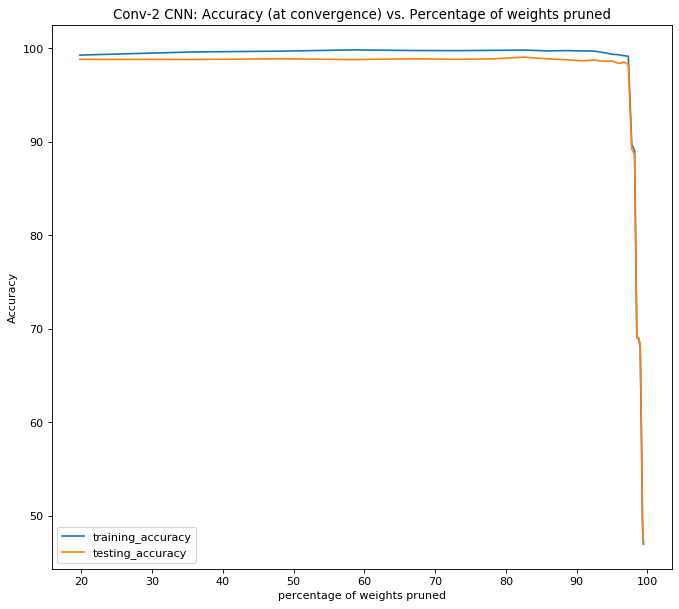

In [81]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("Conv-2 CNN: Accuracy (at convergence) vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [58]:
# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}

In [59]:
# populate 'plot_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][epoch_length - 1]


In [60]:
# populate 'plot_test_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][epoch_length - 1]


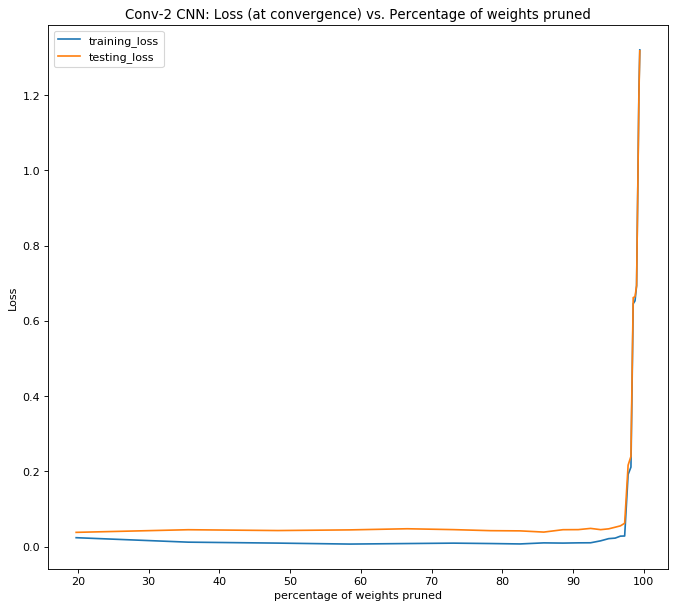

In [82]:
# Visualization of training and testing loss VS percentage of remaining weights-
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("Conv-2 CNN: Loss (at convergence) vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [62]:
# Plot number of epochs (Early Stopping) VS percentage of weights pruned-

# Python 3 dict to hold number of epochs vs % of weights pruned-
plot_num_epochs = {}
plot_num_epochs_test = {}


In [63]:
'''
for k in history_main.keys():
	num_epochs = len(history_main[k]['accuracy'])
	print("number of epochs = {0}, % of weights remaining = {1:.4f}%".format(num_epochs, history_main[k]['percentage_wts_pruned']))
'''

# populate 'plot_num_epochs'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['accuracy'])
    plot_num_epochs[history_main[k]['percentage_wts_pruned']] = num_epochs


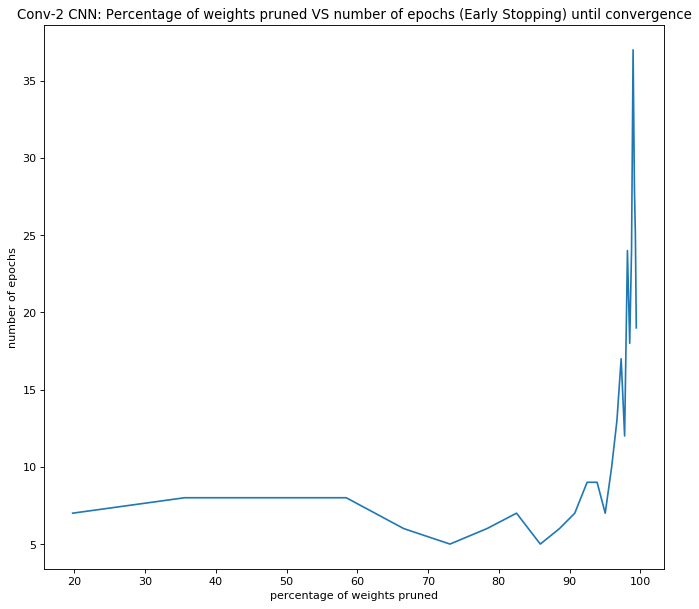

In [83]:
# Visualize percentage of weights remaining VS number of epochs (Early Stopping)
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_num_epochs.keys()), list(plot_num_epochs.values()))

plt.title("Conv-2 CNN: Percentage of weights pruned VS number of epochs (Early Stopping) until convergence")
plt.xlabel("percentage of weights pruned")
plt.ylabel("number of epochs")
plt.show()


In [65]:
# Try to visualize the STARTING training and testing accuracy VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_accuracy = {}
plot_starting_test_accuracy = {}

# Key:    percentage of weights pruned
# Value:  starting accuracy


In [66]:
# populate 'plot_starting_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][0]


In [67]:
# populate 'plot_starting_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][0]


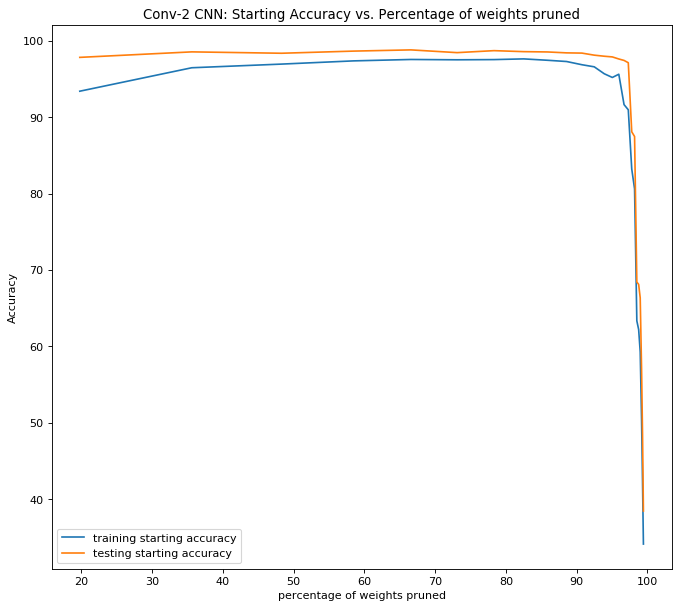

In [84]:
# Visualize starting accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_accuracy.keys()), list(plot_starting_accuracy.values()), label = 'training starting accuracy')
plt.plot(list(plot_starting_test_accuracy.keys()), list(plot_starting_test_accuracy.values()), label = 'testing starting accuracy')

plt.title("Conv-2 CNN: Starting Accuracy vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [69]:
# Try to visualize the STARTING training and testing loss VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_loss = {}
plot_starting_test_loss = {}

# Key:		percentage of weights pruned
# Value:	starting loss


In [70]:
# Populate 'plot_starting_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][0]


In [71]:
# Populate 'plot_starting_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][0]


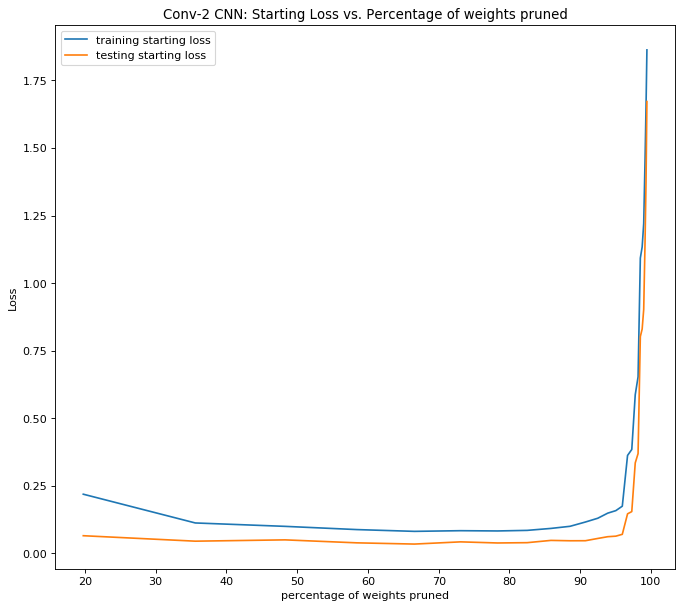

In [85]:
# Visualize Starting training & testing loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_loss.keys()), list(plot_starting_loss.values()), label = 'training starting loss')
plt.plot(list(plot_starting_test_loss.keys()), list(plot_starting_test_loss.values()), label = 'testing starting loss')

plt.title("Conv-2 CNN: Starting Loss vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [73]:
# Try to visualize: percentage of weights remaining VS BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		percentage of weights pruned
# Value:	best accuracy

In [74]:
# Populate 'plot_best_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['accuracy'])


In [75]:
# Populate 'plot_best_test_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_test_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['val_accuracy'])


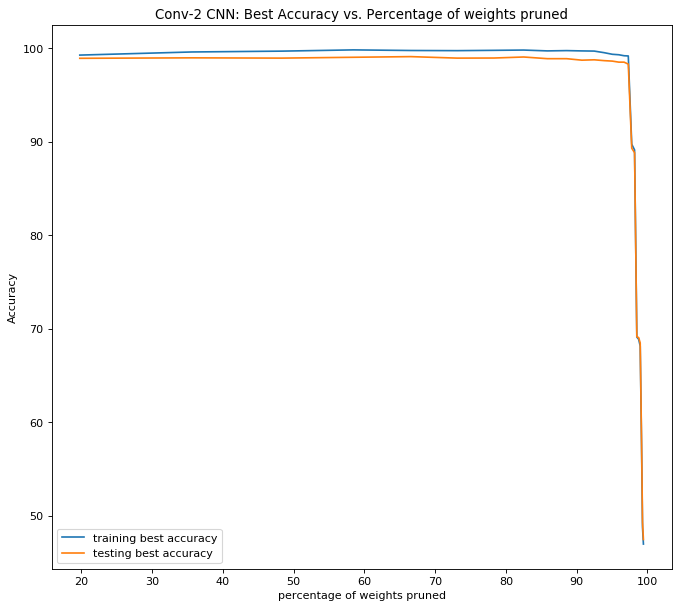

In [86]:
# Visualize best accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'training best accuracy')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'testing best accuracy')

plt.title("Conv-2 CNN: Best Accuracy vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [87]:
# Try to visualize: percentage of weights remaining VS LOWEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		percentage of weights pruned
# Value:	best loss

In [88]:
# Populate 'plot_best_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['loss'])


In [89]:
# Populate 'plot_best_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_test_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['val_loss'])


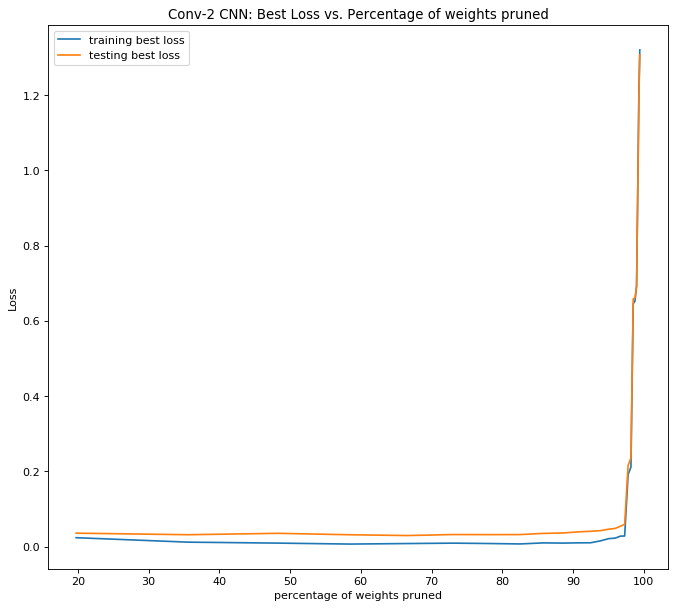

In [90]:
# Visualize best loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'training best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'testing best loss')

plt.title("Conv-2 CNN: Best Loss vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()


### Find the iterative pruning round for which training and testing accuracy is highest:

In [91]:
# Find highest training and testing accuracy for all iterative pruning rounds-
best_accuracy = 0
iterative_round = 0


for k in history_main.keys():
	epoch_length = len(history_main[k]['accuracy'])
	if history_main[k]['accuracy'][epoch_length - 1] > best_accuracy:
		best_accuracy = history_main[k]['accuracy'][epoch_length - 1]
		iterative_round = k


print("\nIterative round = {0} has highest training accuracy = {1:.4f}% at percentage of weights pruned = {2:.4f}%\n".format(
    iterative_round, best_accuracy, history_main[iterative_round]['percentage_wts_pruned']))



Iterative round = 4 has highest training accuracy = 99.8000% at percentage of weights pruned = 58.4313%



In [92]:
best_test_accuracy = 0
iterative_round = 0


for k in history_main.keys():
	epoch_length = len(history_main[k]['val_accuracy'])
	if history_main[k]['val_accuracy'][epoch_length - 1] > best_test_accuracy:
		best_test_accuracy = history_main[k]['val_accuracy'][epoch_length - 1]
		iterative_round = k


print("\nIterative round = {0} has highest testing accuracy = {1:.4f}% at percentage of weights pruned = {2:.4f}%\n".format(
    iterative_round, best_test_accuracy, history_main[iterative_round]['percentage_wts_pruned']))



Iterative round = 8 has highest testing accuracy = 99.0300% at percentage of weights pruned = 82.4983%



In [93]:
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    '''
    print("Iterative pruning round = {0}, val accuracy = {1:.4f}%".format(
        k, history_main[k]['val_accuracy'][epoch_length - 1]))
    '''
    print("% of wts pruned = {0:.4f}%, val accuracy = {1:.4f}%, # of epochs = {2}".format(
        history_main[k]['percentage_wts_pruned'], history_main[k]['val_accuracy'][epoch_length - 1],
        len(history_main[k]['loss'])
    ))

% of wts pruned = 19.7673%, val accuracy = 98.7900%, # of epochs = 7
% of wts pruned = 35.5978%, val accuracy = 98.7700%, # of epochs = 8
% of wts pruned = 48.2771%, val accuracy = 98.8500%, # of epochs = 8
% of wts pruned = 58.4313%, val accuracy = 98.7600%, # of epochs = 8
% of wts pruned = 66.5662%, val accuracy = 98.8500%, # of epochs = 6
% of wts pruned = 73.0915%, val accuracy = 98.7900%, # of epochs = 5
% of wts pruned = 78.3117%, val accuracy = 98.8400%, # of epochs = 6
% of wts pruned = 82.4983%, val accuracy = 99.0300%, # of epochs = 7
% of wts pruned = 85.8574%, val accuracy = 98.8400%, # of epochs = 5
% of wts pruned = 88.5641%, val accuracy = 98.7500%, # of epochs = 6
% of wts pruned = 90.7298%, val accuracy = 98.6300%, # of epochs = 7
% of wts pruned = 92.4743%, val accuracy = 98.7200%, # of epochs = 9
% of wts pruned = 93.8875%, val accuracy = 98.5800%, # of epochs = 9
% of wts pruned = 95.0311%, val accuracy = 98.6000%, # of epochs = 7
% of wts pruned = 95.9450%, val ac